In [1]:
import torch
from algo_reasoning.src.sampler import CLRSDataset
from pathlib import Path
import math

device = torch.device("cpu")

/opt/miniconda3/envs/algo_reasoning/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def homophily_measure(adj_matrix, classes):
    """
    Compute the homophily measure of the graph
    """
    n = adj_matrix.shape[0]
    homophily = 0
    
    for i in range(n):
        node_homophily = 0
        for j in range(n):
            if classes[i] == classes[j]:
                node_homophily += adj_matrix[i, j]

        node_homophily /= adj_matrix[i].sum()
        homophily += node_homophily

    homophily /= n
    return homophily

In [77]:
def unbiased_homophily(adj_matrix, classes):
    """
    Compute the unbiased homophily measure of the graph
    As described in (https://arxiv.org/pdf/2412.09663)
    """
    classes_unique = torch.unique(classes).int()
    n_classes = classes_unique.size(0)
    n_nodes = adj_matrix.size(0)
    n_edges = 0

    class_adj_matrix = torch.zeros(n_classes, n_classes)

    edges_classes = dict()

    for c1 in classes_unique.tolist():
        for c2 in classes_unique.tolist():
            edges_classes[(c1, c2)] = []

    for i in range(n_nodes):
        for j in range(i + 1, n_nodes):
            if adj_matrix[i, j] > 0:
                n_edges += 1
                class_i = classes[i].item()
                class_j = classes[j].item()

                edges_classes[(class_i, class_j)].append((i, j))

    for c1 in classes_unique.tolist():
        for c2 in classes_unique.tolist():
            class_adj_matrix[c1, c2] = len(edges_classes[(c1, c2)]) + len(edges_classes[(c2, c1)])

            if c1 == c2:
                class_adj_matrix[c1, c2] /= n_edges
            else:
                class_adj_matrix[c1, c2] /= 2*n_edges

    numerator = 0
    denominator = 0
    for c1 in classes_unique.tolist():
        filtered_classes = classes_unique[classes_unique > c1].tolist()
        for c2 in filtered_classes:
            numerator += torch.sqrt(class_adj_matrix[c1, c1]*class_adj_matrix[c2, c2]) - class_adj_matrix[c1, c2]
            denominator += torch.sqrt(class_adj_matrix[c1, c1]*class_adj_matrix[c2, c2]) + class_adj_matrix[c1, c2]
    
    return (numerator/denominator).item()

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_homophilies(homophilies, fig_title):
    hfont = {'fontname':'Courier New', "fontweight":"bold"}


    plt.figure(figsize=(30, 5), dpi=80)

    for i, column in enumerate(homophilies["graph_size"]):
        plt.subplot(1,5,i + 1)
        plt.subplots_adjust(top=0.8)
        sns.histplot(homophilies["homophilies"][i], kde=True, bins=15)
        plt.rc('axes', titlesize=14)
        plt.title("Graph Size = "+str(homophilies["graph_size"][i]), **hfont)
        if i > 0:
            plt.ylabel('')

    plt.rc('figure', titlesize=20)
    plt.suptitle(fig_title, **hfont)
    plt.show()

# Articulation Points

In [79]:
algorithms = ["articulation_points"]

batch_size = 64
articulation_points_16 = CLRSDataset(algorithms, [16], batch_size, 1000, seed=7, algorithms_args={'p': [0.05, 0.1, 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45]})
articulation_points_13 = CLRSDataset(algorithms, [13], batch_size, 1000, seed=7, algorithms_args={'p': [0.05, 0.1, 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45]})
articulation_points_11 = CLRSDataset(algorithms, [11], batch_size, 1000, seed=7, algorithms_args={'p': [0.05, 0.1, 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45]})
articulation_points_7 = CLRSDataset(algorithms, [7], batch_size*2, 1000, seed=7, algorithms_args={'p': [0.05, 0.1, 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45]})
articulation_points_4 = CLRSDataset(algorithms, [4], batch_size*4, 1000, seed=7, algorithms_args={'p': [0.05, 0.1, 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45]})

In [80]:
obj_16 = next(iter(articulation_points_16))
obj_13 = next(iter(articulation_points_13))
obj_11 = next(iter(articulation_points_11))
obj_7 = next(iter(articulation_points_7))
obj_4 = next(iter(articulation_points_4))

In [81]:
homophilies_16 = [unbiased_homophily(obj_16.inputs.A[i], obj_16.outputs.is_cut[i]) for i in range(batch_size) if torch.sum(obj_16.outputs.is_cut[i]).item() > 0]
homophilies_13 = [unbiased_homophily(obj_13.inputs.A[i], obj_13.outputs.is_cut[i]) for i in range(batch_size) if torch.sum(obj_13.outputs.is_cut[i]).item() > 0]
homophilies_11 = [unbiased_homophily(obj_11.inputs.A[i], obj_11.outputs.is_cut[i]) for i in range(batch_size) if torch.sum(obj_11.outputs.is_cut[i]).item() > 0]
homophilies_7 = [unbiased_homophily(obj_7.inputs.A[i], obj_7.outputs.is_cut[i]) for i in range(batch_size*2) if torch.sum(obj_7.outputs.is_cut[i]).item() > 0]
homophilies_4 = [unbiased_homophily(obj_4.inputs.A[i], obj_4.outputs.is_cut[i]) for i in range(batch_size*4) if torch.sum(obj_4.outputs.is_cut[i]).item() > 0]

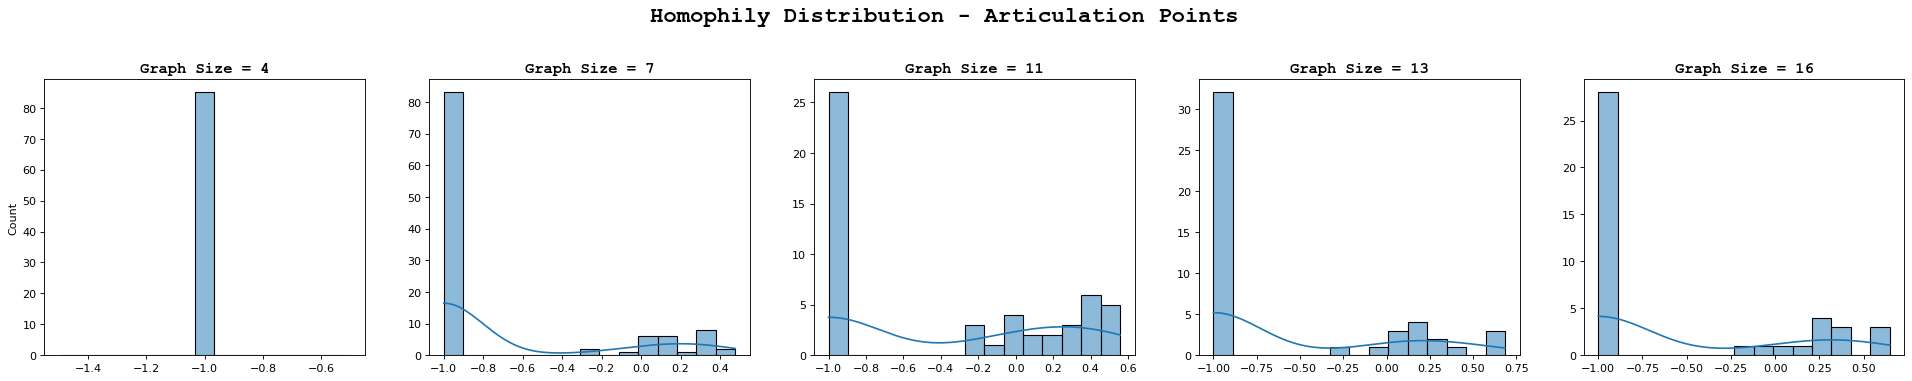

In [82]:
homophilies = {
    "graph_size": [4, 7, 11, 13, 16],
    "homophilies": [homophilies_4, homophilies_7, homophilies_11, homophilies_13, homophilies_16]
}

plot_homophilies(homophilies, "Homophily Distribution - Articulation Points")

# Activity Selector

In [83]:
from algo_reasoning.src.models.encoder import preprocess
from algo_reasoning.src.specs import Location, Type, SPECS

def accum_adj_matrix(adj_matrix, _input):
    _input = _input.squeeze(-1)
    adj_matrix += ((_input + _input.permute((0, 2, 1))) > 0.0)

    return adj_matrix

def build_adj_matrix(obj, batch_size, nb_nodes, algorithm, hint_step=None):
    adj_mat = (torch.zeros((nb_nodes, nb_nodes), device=device)[None, :, :]).repeat(batch_size, 1, 1).bool()
    
    for k, value in obj.inputs:
        if k not in SPECS[algorithm]:
            continue
            
        _, loc, type_ = SPECS[algorithm][k]
        _input = preprocess(value, type_, nb_nodes)

        if loc == Location.NODE and type_ == Type.POINTER:
            adj_mat = accum_adj_matrix(adj_mat, _input)
                
        elif loc == Location.EDGE and type_ == Type.MASK:
            adj_mat = accum_adj_matrix(adj_mat, _input)

    if hint_step is not None:
        for k, value in obj.hints:
            if k not in SPECS[algorithm]:
                continue

            
            _, loc, type_ = SPECS[algorithm][k]
            
            value = value[:, hint_step]
            _input = preprocess(value, type_, nb_nodes)

            if loc == Location.NODE and type_ == Type.POINTER:
                adj_mat = accum_adj_matrix(adj_mat, _input)
                    
            elif loc == Location.EDGE and type_ == Type.MASK:
                adj_mat = accum_adj_matrix(adj_mat, _input)

    return adj_mat.float()

In [84]:
algorithms = ["activity_selector"]

batch_size = 128
activity_selector_16 = CLRSDataset(algorithms, [16], batch_size, 1000, seed=7)
activity_selector_13 = CLRSDataset(algorithms, [13], batch_size, 1000, seed=7)
activity_selector_11 = CLRSDataset(algorithms, [11], batch_size, 1000, seed=7)
activity_selector_7 = CLRSDataset(algorithms, [7], batch_size, 1000, seed=7)
activity_selector_4 = CLRSDataset(algorithms, [4], batch_size, 1000, seed=7)

In [85]:
obj_16 = next(iter(activity_selector_16))
obj_13 = next(iter(activity_selector_13))
obj_11 = next(iter(activity_selector_11))
obj_7 = next(iter(activity_selector_7))
obj_4 = next(iter(activity_selector_4))

In [86]:
adj_mat_16 = build_adj_matrix(obj_16, batch_size, 16, algorithms[0], hint_step=-1)
adj_mat_13 = build_adj_matrix(obj_13, batch_size, 13, algorithms[0], hint_step=-1)
adj_mat_11 = build_adj_matrix(obj_11, batch_size, 11, algorithms[0], hint_step=-1)
adj_mat_7 = build_adj_matrix(obj_7, batch_size, 7, algorithms[0], hint_step=-1)
adj_mat_4 = build_adj_matrix(obj_4, batch_size, 4, algorithms[0], hint_step=-1)

In [87]:
homophilies_16 = [unbiased_homophily(adj_mat_16[i], obj_16.outputs.selected[i]) for i in range(128) if torch.unique(obj_16.outputs.selected[i]).int().size(0) > 1]
homophilies_13 = [unbiased_homophily(adj_mat_13[i], obj_13.outputs.selected[i]) for i in range(128) if torch.unique(obj_13.outputs.selected[i]).int().size(0) > 1]
homophilies_11 = [unbiased_homophily(adj_mat_11[i], obj_11.outputs.selected[i]) for i in range(128) if torch.unique(obj_11.outputs.selected[i]).int().size(0) > 1]
homophilies_7 = [unbiased_homophily(adj_mat_7[i], obj_7.outputs.selected[i]) for i in range(128) if torch.unique(obj_7.outputs.selected[i]).int().size(0) > 1]
homophilies_4 = [unbiased_homophily(adj_mat_4[i], obj_4.outputs.selected[i]) for i in range(128) if torch.unique(obj_4.outputs.selected[i]).int().size(0) > 1]

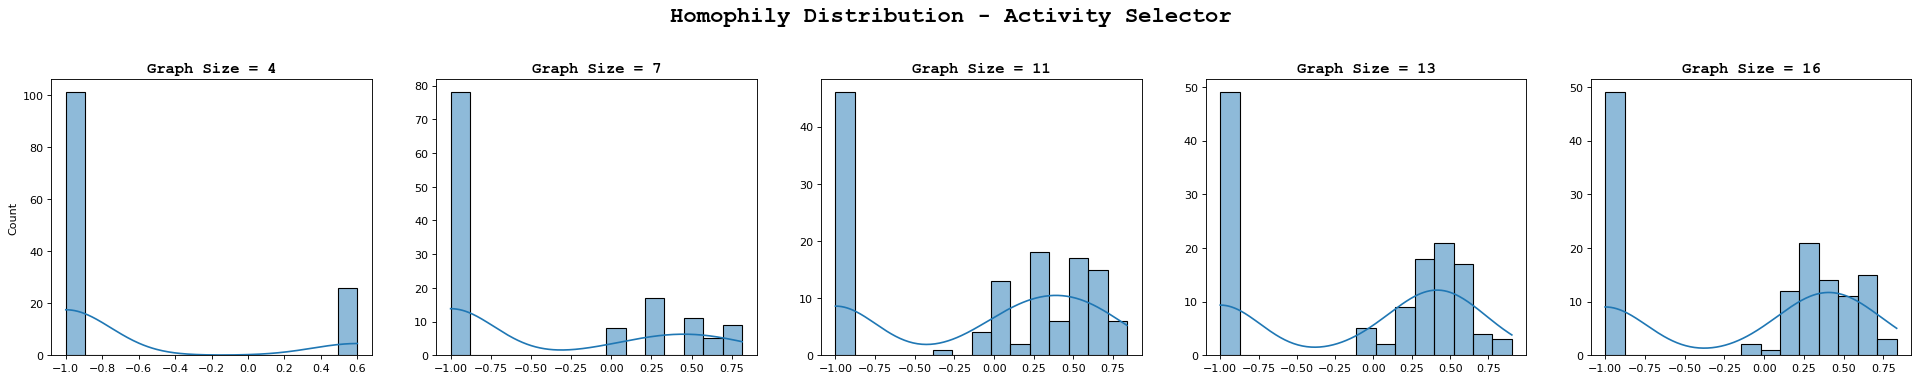

In [88]:
homophilies = {
    "graph_size": [4, 7, 11, 13, 16],
    "homophilies": [homophilies_4, homophilies_7, homophilies_11, homophilies_13, homophilies_16]
}

plot_homophilies(homophilies, "Homophily Distribution - Activity Selector")

# Task Scheduling

In [89]:
algorithms = ["task_scheduling"]

batch_size = 128
task_scheduling_16 = CLRSDataset(algorithms, [16], batch_size, 1000, seed=7)
task_scheduling_13 = CLRSDataset(algorithms, [13], batch_size, 1000, seed=7)
task_scheduling_11 = CLRSDataset(algorithms, [11], batch_size, 1000, seed=7)
task_scheduling_7 = CLRSDataset(algorithms, [7], batch_size, 1000, seed=7)
task_scheduling_4 = CLRSDataset(algorithms, [4], batch_size, 1000, seed=7)

In [90]:
obj_16 = next(iter(task_scheduling_16))
obj_13 = next(iter(task_scheduling_13))
obj_11 = next(iter(task_scheduling_11))
obj_7 = next(iter(task_scheduling_7))
obj_4 = next(iter(task_scheduling_4))

In [91]:
adj_mat_16 = build_adj_matrix(obj_16, batch_size, 16, algorithms[0], hint_step=-1)
adj_mat_13 = build_adj_matrix(obj_13, batch_size, 13, algorithms[0], hint_step=-1)
adj_mat_11 = build_adj_matrix(obj_11, batch_size, 11, algorithms[0], hint_step=-1)
adj_mat_7 = build_adj_matrix(obj_7, batch_size, 7, algorithms[0], hint_step=-1)
adj_mat_4 = build_adj_matrix(obj_4, batch_size, 4, algorithms[0], hint_step=-1)

In [92]:
homophilies_16 = [unbiased_homophily(adj_mat_16[i], obj_16.outputs.selected[i]) for i in range(128) if torch.unique(obj_16.outputs.selected[i]).int().size(0) > 1]
homophilies_13 = [unbiased_homophily(adj_mat_13[i], obj_13.outputs.selected[i]) for i in range(128) if torch.unique(obj_13.outputs.selected[i]).int().size(0) > 1]
homophilies_11 = [unbiased_homophily(adj_mat_11[i], obj_11.outputs.selected[i]) for i in range(128) if torch.unique(obj_11.outputs.selected[i]).int().size(0) > 1]
homophilies_7 = [unbiased_homophily(adj_mat_7[i], obj_7.outputs.selected[i]) for i in range(128) if torch.unique(obj_7.outputs.selected[i]).int().size(0) > 1]
homophilies_4 = [unbiased_homophily(adj_mat_4[i], obj_4.outputs.selected[i]) for i in range(128) if torch.unique(obj_4.outputs.selected[i]).int().size(0) > 1]

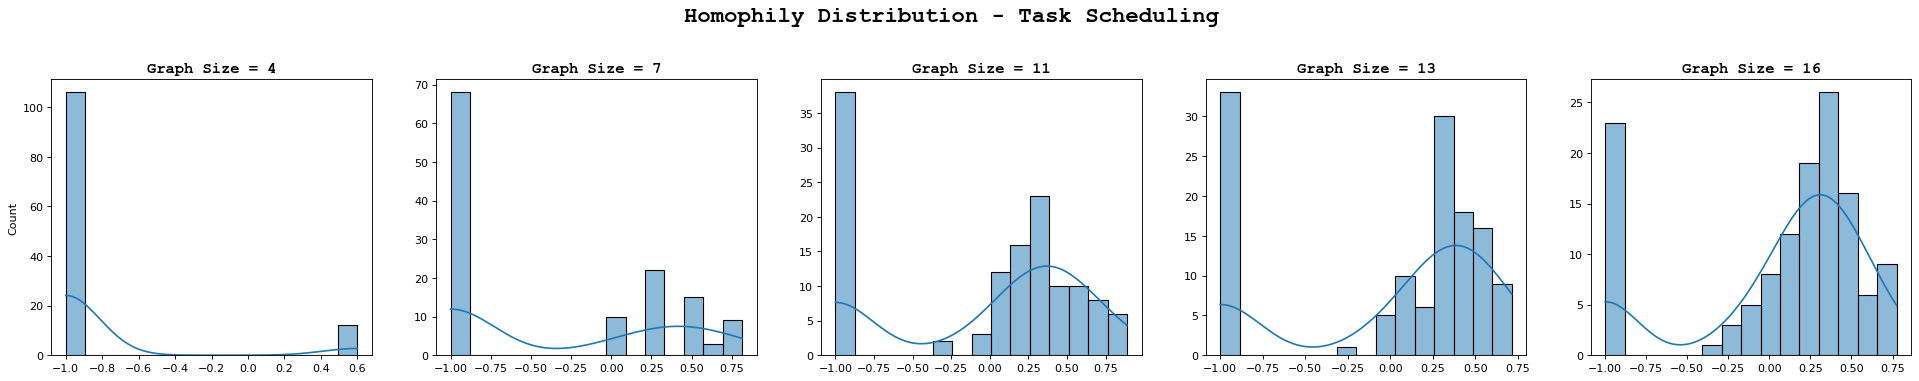

In [93]:
homophilies = {
    "graph_size": [4, 7, 11, 13, 16],
    "homophilies": [homophilies_4, homophilies_7, homophilies_11, homophilies_13, homophilies_16]
}

plot_homophilies(homophilies, "Homophily Distribution - Task Scheduling")

# Graham Scan

In [94]:
algorithms = ["graham_scan"]

batch_size = 128
graham_scan_16 = CLRSDataset(algorithms, [16], batch_size, 1000, seed=7)
graham_scan_13 = CLRSDataset(algorithms, [13], batch_size, 1000, seed=7)
graham_scan_11 = CLRSDataset(algorithms, [11], batch_size, 1000, seed=7)
graham_scan_7 = CLRSDataset(algorithms, [7], batch_size, 1000, seed=7)
graham_scan_4 = CLRSDataset(algorithms, [4], batch_size, 1000, seed=7)

In [95]:
obj_16 = next(iter(graham_scan_16))
obj_13 = next(iter(graham_scan_13))
obj_11 = next(iter(graham_scan_11))
obj_7 = next(iter(graham_scan_7))
obj_4 = next(iter(graham_scan_4))

In [ ]:
adj_mat_16 = build_adj_matrix(obj_16, batch_size, 16, algorithms[0], hint_step=5)
adj_mat_13 = build_adj_matrix(obj_13, batch_size, 13, algorithms[0], hint_step=5)
adj_mat_11 = build_adj_matrix(obj_11, batch_size, 11, algorithms[0], hint_step=5)
adj_mat_7 = build_adj_matrix(obj_7, batch_size, 7, algorithms[0], hint_step=5)
adj_mat_4 = build_adj_matrix(obj_4, batch_size, 4, algorithms[0], hint_step=5)

In [98]:
homophilies_16 = [unbiased_homophily(adj_mat_16[i], obj_16.outputs.in_hull[i]) for i in range(128) if torch.unique(obj_16.outputs.in_hull[i]).int().size(0) > 1]
homophilies_13 = [unbiased_homophily(adj_mat_13[i], obj_13.outputs.in_hull[i]) for i in range(128) if torch.unique(obj_13.outputs.in_hull[i]).int().size(0) > 1]
homophilies_11 = [unbiased_homophily(adj_mat_11[i], obj_11.outputs.in_hull[i]) for i in range(128) if torch.unique(obj_11.outputs.in_hull[i]).int().size(0) > 1]
homophilies_7 = [unbiased_homophily(adj_mat_7[i], obj_7.outputs.in_hull[i]) for i in range(128) if torch.unique(obj_7.outputs.in_hull[i]).int().size(0) > 1]
homophilies_4 = [unbiased_homophily(adj_mat_4[i], obj_4.outputs.in_hull[i]) for i in range(128) if torch.unique(obj_4.outputs.in_hull[i]).int().size(0) > 1]

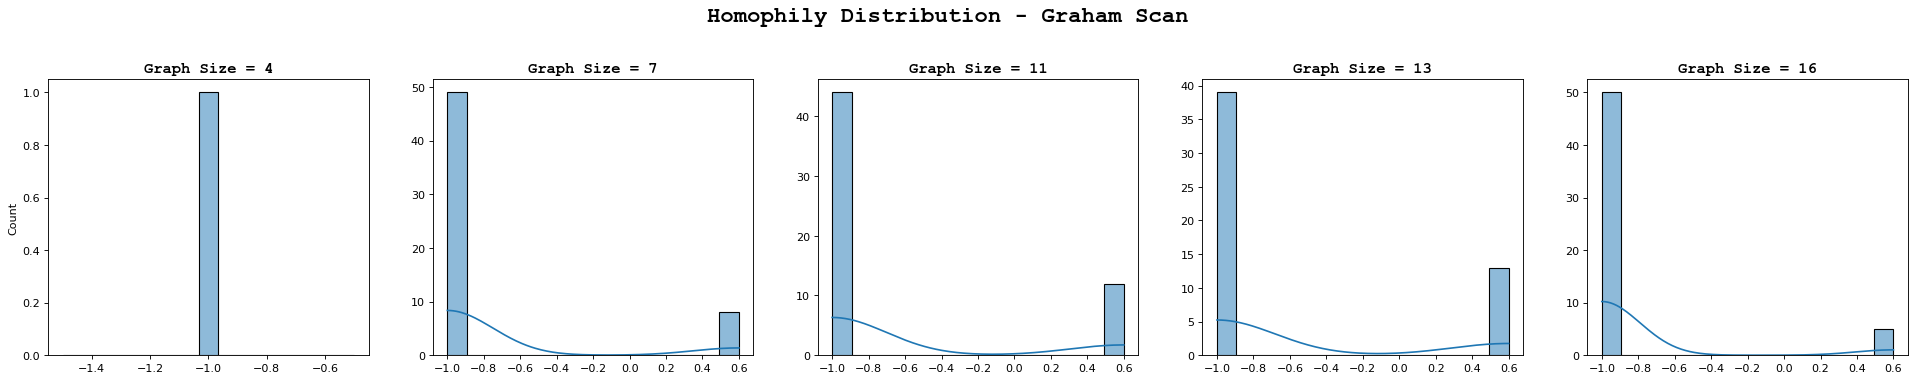

In [102]:
homophilies = {
    "graph_size": [4, 7, 11, 13, 16],
    "homophilies": [homophilies_4, homophilies_7, homophilies_11, homophilies_13, homophilies_16]
}

plot_homophilies(homophilies, "Homophily Distribution - Graham Scan")

# Jarvis March

In [105]:
algorithms = ["jarvis_march"]

batch_size = 128
jarvis_march_16 = CLRSDataset(algorithms, [16], batch_size, 1000, seed=7)
jarvis_march_13 = CLRSDataset(algorithms, [13], batch_size, 1000, seed=7)
jarvis_march_11 = CLRSDataset(algorithms, [11], batch_size, 1000, seed=7)
jarvis_march_7 = CLRSDataset(algorithms, [7], batch_size, 1000, seed=7)
jarvis_march_4 = CLRSDataset(algorithms, [4], batch_size, 1000, seed=7)

In [106]:
obj_16 = next(iter(jarvis_march_16))
obj_13 = next(iter(jarvis_march_13))
obj_11 = next(iter(jarvis_march_11))
obj_7 = next(iter(jarvis_march_7))
obj_4 = next(iter(jarvis_march_4))

In [107]:
adj_mat_16 = build_adj_matrix(obj_16, batch_size, 16, algorithms[0], hint_step=-1)
adj_mat_13 = build_adj_matrix(obj_13, batch_size, 13, algorithms[0], hint_step=-1)
adj_mat_11 = build_adj_matrix(obj_11, batch_size, 11, algorithms[0], hint_step=-1)
adj_mat_7 = build_adj_matrix(obj_7, batch_size, 7, algorithms[0], hint_step=-1)
adj_mat_4 = build_adj_matrix(obj_4, batch_size, 4, algorithms[0], hint_step=-1)

In [108]:
homophilies_16 = [unbiased_homophily(adj_mat_16[i], obj_16.outputs.in_hull[i]) for i in range(128) if torch.unique(obj_16.outputs.in_hull[i]).int().size(0) > 1]
homophilies_13 = [unbiased_homophily(adj_mat_13[i], obj_13.outputs.in_hull[i]) for i in range(128) if torch.unique(obj_13.outputs.in_hull[i]).int().size(0) > 1]
homophilies_11 = [unbiased_homophily(adj_mat_11[i], obj_11.outputs.in_hull[i]) for i in range(128) if torch.unique(obj_11.outputs.in_hull[i]).int().size(0) > 1]
homophilies_7 = [unbiased_homophily(adj_mat_7[i], obj_7.outputs.in_hull[i]) for i in range(128) if torch.unique(obj_7.outputs.in_hull[i]).int().size(0) > 1]
homophilies_4 = [unbiased_homophily(adj_mat_4[i], obj_4.outputs.in_hull[i]) for i in range(128) if torch.unique(obj_4.outputs.in_hull[i]).int().size(0) > 1]

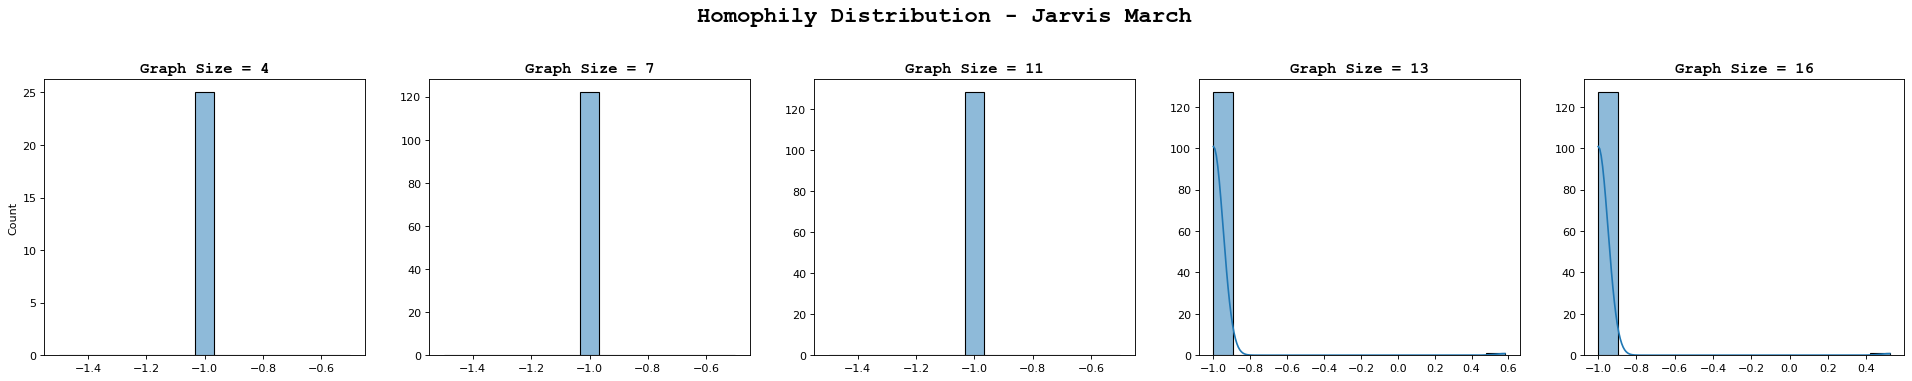

In [109]:
homophilies = {
    "graph_size": [4, 7, 11, 13, 16],
    "homophilies": [homophilies_4, homophilies_7, homophilies_11, homophilies_13, homophilies_16]
}

plot_homophilies(homophilies, "Homophily Distribution - Jarvis March")